In [3]:
# sales_forecast_from_excel.py

import warnings
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error
import json

warnings.filterwarnings("ignore", category=FutureWarning)

# Try Prophet first, fallback Holt-Winters
try:
    from prophet import Prophet
    use_prophet = True
except ImportError:
    from statsmodels.tsa.holtwinters import ExponentialSmoothing
    use_prophet = False


def preprocess(df):
    """Preprocess sales data: fill missing months & values per product."""
    processed = []

    for prod, g in df.groupby("product_code"):
        g = g.set_index("date").asfreq("MS")  # ensure monthly frequency
        # Fill missing values
        if g["sales"].isna().sum() > 0:
            month_medians = g.groupby(g.index.month)["sales"].transform("median")
            g["sales"] = g["sales"].fillna(month_medians)
            g["sales"] = g["sales"].interpolate().ffill().bfill()
        g["product_code"] = prod
        g = g.reset_index()
        processed.append(g)

    return pd.concat(processed)


def train_forecast(df, horizon=3):
    """Train Prophet/HoltWinters, forecast horizon months, evaluate on last 6 months."""
    forecasts_by_date = []
    metrics = []

    for prod, g in df.groupby("product_code"):
        g = g.sort_values("date")
        train, test = g.iloc[:-6], g.iloc[-6:]

        # Train model
        if use_prophet:
            model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
            model.fit(train.rename(columns={"date": "ds", "sales": "y"}))
            future = model.make_future_dataframe(periods=horizon + len(test), freq="MS")
            fc = model.predict(future)[["ds", "yhat"]].set_index("ds").tail(len(test) + horizon)
            fc = fc.rename(columns={"yhat": "forecast"})
        else:
            model = ExponentialSmoothing(train["sales"], seasonal="add", seasonal_periods=12)
            model = model.fit()
            fc_vals = model.forecast(len(test) + horizon)
            fc = pd.DataFrame({
                "ds": pd.date_range(train["date"].iloc[-1], periods=len(test) + horizon + 1, freq="MS")[1:],
                "forecast": fc_vals
            }).set_index("ds")

        # MAPE on test
        y_true = test.set_index("date")["sales"].values
        y_pred = fc.iloc[:len(test)]["forecast"].values
        mape = mean_absolute_percentage_error(y_true, y_pred) * 100
        acc = 100 - mape
        metrics.append({"product_code": prod, "mape": round(mape, 2), "accuracy": round(acc, 2)})

        # Future 3 months → round to integers
        fc_future = fc.iloc[len(test):len(test)+horizon]
        for d, val in fc_future["forecast"].items():
            d_str = str(d.date())
            # If date already exists in dict, append product value
            if any(d_str in f for f in forecasts_by_date):
                for f in forecasts_by_date:
                    if d_str in f:
                        f[d_str][prod] = int(round(val))
            else:
                forecasts_by_date.append({d_str: {prod: int(round(val))}})

        # Plot chart
        plt.figure(figsize=(8, 4))
        plt.plot(g["date"], g["sales"], label="Actual", color="blue")
        plt.plot(fc.index, fc["forecast"], label="Forecast", color="red")
        plt.axvline(test["date"].iloc[0], color="gray", linestyle="--", label="Train/Test Split")
        plt.title(f"Product {prod} Forecast")
        plt.legend()
        plt.tight_layout()
        plt.show()

    return {"forecasted_products": forecasts_by_date, "metrics": metrics}


def main():
    input_file = "inventory_sales.xlsx"   # <-- Excel file

    # Load Excel
    raw = pd.read_excel(input_file, parse_dates=["date"])
    print("✅ Data loaded:", raw.shape)

    # Preprocess
    processed = preprocess(raw)

    # Plot preprocessing
    plt.figure(figsize=(8, 4))
    for prod, g in processed.groupby("product_code"):
        plt.plot(g["date"], g["sales"], label=prod)
    plt.title("Preprocessed Sales Data")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Forecast
    result = train_forecast(processed, horizon=3)

    # Output JSON
    print(json.dumps(result, indent=4))


if __name__ == "__main__":
    main()


ModuleNotFoundError: No module named 'statsmodels'

Importing plotly failed. Interactive plots will not work.


✅ Data loaded: (180, 3)


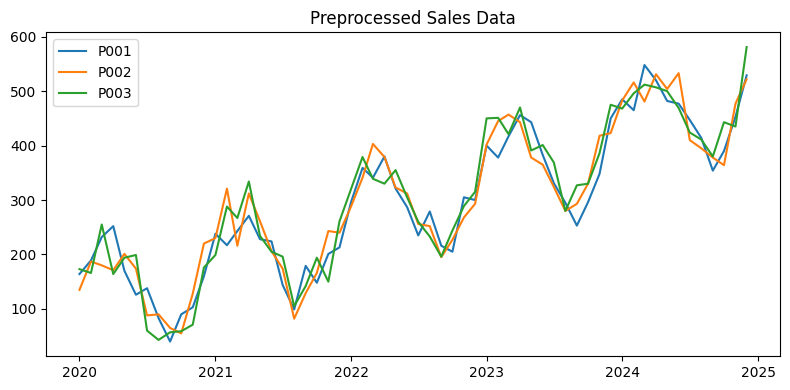

01:00:17 - cmdstanpy - INFO - Chain [1] start processing
01:00:18 - cmdstanpy - INFO - Chain [1] done processing


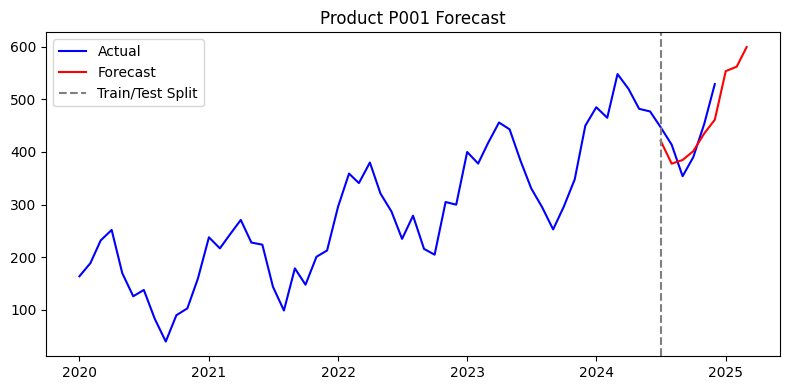

01:00:18 - cmdstanpy - INFO - Chain [1] start processing
01:00:19 - cmdstanpy - INFO - Chain [1] done processing


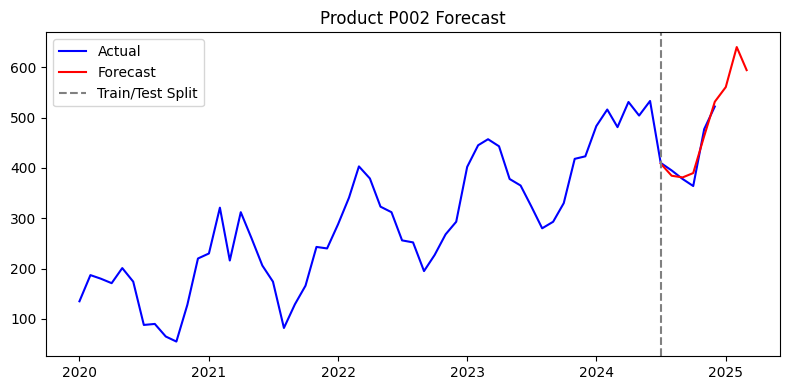

01:00:19 - cmdstanpy - INFO - Chain [1] start processing
01:00:19 - cmdstanpy - INFO - Chain [1] done processing


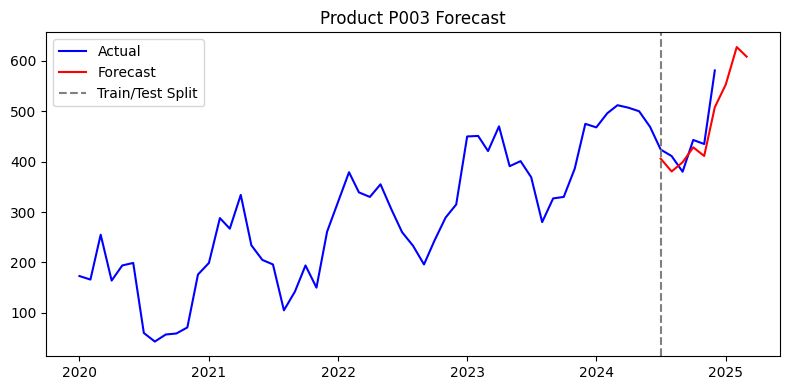

{
    "forecasted_products": [
        {
            "2025-01-01": {
                "P001": 554,
                "P002": 561,
                "P003": 553
            }
        },
        {
            "2025-02-01": {
                "P001": 562,
                "P002": 640,
                "P003": 627
            }
        },
        {
            "2025-03-01": {
                "P001": 599,
                "P002": 594,
                "P003": 608
            }
        }
    ],
    "metrics": [
        {
            "product_code": "P001",
            "sMAPE": 7.34,
            "RMSE": 36.44
        },
        {
            "product_code": "P002",
            "sMAPE": 2.57,
            "RMSE": 13.32
        },
        {
            "product_code": "P003",
            "sMAPE": 6.54,
            "RMSE": 35.87
        }
    ]
}


In [7]:

import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from sklearn.metrics import mean_squared_error

warnings.filterwarnings("ignore", category=FutureWarning)

# Try Prophet first, fallback Holt-Winters
try:
    from prophet import Prophet
    use_prophet = True
except ImportError:
    from statsmodels.tsa.holtwinters import ExponentialSmoothing
    use_prophet = False


# ---------- Metrics ----------
def smape(y_true, y_pred):
    """Symmetric Mean Absolute Percentage Error"""
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))


# ---------- Preprocessing ----------
def preprocess(df):
    """Preprocess sales data: fill missing months & values per product."""
    processed = []

    for prod, g in df.groupby("product_code"):
        g = g.set_index("date").asfreq("MS")  # ensure monthly frequency
        # Fill missing values
        if g["sales"].isna().sum() > 0:
            month_medians = g.groupby(g.index.month)["sales"].transform("median")
            g["sales"] = g["sales"].fillna(month_medians)
            g["sales"] = g["sales"].interpolate().ffill().bfill()
        g["product_code"] = prod
        g = g.reset_index()
        processed.append(g)

    return pd.concat(processed)


# ---------- Train & Forecast ----------
def train_forecast(df, horizon=3):
    forecasts_by_date = []
    metrics = []

    for prod, g in df.groupby("product_code"):
        g = g.sort_values("date")
        train, test = g.iloc[:-6], g.iloc[-6:]

        # Train model
        if use_prophet:
            model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
            model.fit(train.rename(columns={"date": "ds", "sales": "y"}))
            future = model.make_future_dataframe(periods=horizon + len(test), freq="MS")
            fc = model.predict(future)[["ds", "yhat"]].set_index("ds").tail(len(test) + horizon)
            fc = fc.rename(columns={"yhat": "forecast"})
        else:
            model = ExponentialSmoothing(train["sales"], seasonal="add", seasonal_periods=12)
            model = model.fit()
            fc_vals = model.forecast(len(test) + horizon)
            fc = pd.DataFrame({
                "ds": pd.date_range(train["date"].iloc[-1], periods=len(test) + horizon + 1, freq="MS")[1:],
                "forecast": fc_vals
            }).set_index("ds")

        # Clip negative predictions
        fc["forecast"] = fc["forecast"].clip(lower=0)

        # Metrics on test
        y_true = test.set_index("date")["sales"].values
        y_pred = fc.iloc[:len(test)]["forecast"].values
        smape_val = smape(y_true, y_pred)
        rmse_val = np.sqrt(mean_squared_error(y_true, y_pred))

        metrics.append({
            "product_code": prod,
            "sMAPE": round(smape_val, 2),
            "RMSE": round(rmse_val, 2)
        })

        # Future 3 months → round to integers
        fc_future = fc.iloc[len(test):len(test)+horizon]
        for d, val in fc_future["forecast"].items():
            d_str = str(d.date())
            if any(d_str in f for f in forecasts_by_date):
                for f in forecasts_by_date:
                    if d_str in f:
                        f[d_str][prod] = int(round(val))
            else:
                forecasts_by_date.append({d_str: {prod: int(round(val))}})

        # Plot chart
        plt.figure(figsize=(8, 4))
        plt.plot(g["date"], g["sales"], label="Actual", color="blue")
        plt.plot(fc.index, fc["forecast"], label="Forecast", color="red")
        plt.axvline(test["date"].iloc[0], color="gray", linestyle="--", label="Train/Test Split")
        plt.title(f"Product {prod} Forecast")
        plt.legend()
        plt.tight_layout()
        plt.show()

    return {"forecasted_products": forecasts_by_date, "metrics": metrics}


# ---------- Main ----------
def main():
    input_file = "inventory_sales.xlsx"   # <-- your Excel file

    # Load Excel
    raw = pd.read_excel(input_file)
    raw["date"] = pd.to_datetime(raw["date"], errors="coerce")  # fix ###### issue
    print("✅ Data loaded:", raw.shape)

    # Preprocess
    processed = preprocess(raw)

    # Plot preprocessing
    plt.figure(figsize=(8, 4))
    for prod, g in processed.groupby("product_code"):
        plt.plot(g["date"], g["sales"], label=prod)
    plt.title("Preprocessed Sales Data")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Forecast
    result = train_forecast(processed, horizon=3)

    # Output JSON
    print(json.dumps(result, indent=4))


if __name__ == "__main__":
    main()
